<a href="https://colab.research.google.com/github/AlexandreAdam/ExoRIM/blob/dev/notebooks/exorim_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/ExoRIM.git
%cd ExoRIM
!git checkout dev

Cloning into 'ExoRIM'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (509/509), done.
remote: Compressing objects: 100% (352/352), done.
remote: Total 1144 (delta 327), reused 318 (delta 156), pack-reused 635
Receiving objects: 100% (1144/1144), 21.00 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (718/718), done.
/content/ExoRIM
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


In [2]:
!pip install wandb
!python setup.py develop
!pip install celluloid

     |████████████████████████████████| 2.1MB 15.7MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 163kB 31.8MB/s 
     |████████████████████████████████| 133kB 57.7MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=7d9dd32252a6321aecc0f9a373476fb509da0ad681fb7bdcd31b2aabe0aca2f6
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=dbb3d55434b0a74096e87e5343a366a5647f775e01e87662c2ccfdb86ead1658
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
running develop
running egg_info
creating exorim.egg-info
writing exorim.egg-info/PKG-INFO
writing dependency_links to exorim.egg-info/dependency_li

In [3]:
from exorim import RIM, MSE, PhysicalModel
from preprocessing.simulate_data import create_and_save_data
from exorim.interferometry.simulated_data import CenteredBinaries 
from exorim.definitions import DTYPE, rad2mas
from exorim.utilities import create_dataset_from_generator, replay_dataset_from_generator
from argparse import ArgumentParser
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
import os
import wandb

import matplotlib.pyplot as plt
from glob import glob
from celluloid import Camera
import collections
import pickle
from IPython.display import HTML

import exorim.inference.log_likelihood as chisq

os.mkdir("logs")

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
def create_datasets(meta_data, rim, dirname, batch_size=None, index_save_mod=1, format="txt"):
    images = tf.convert_to_tensor(create_and_save_data(dirname, meta_data, index_save_mod, format), dtype=DTYPE)
    noisy_data = rim.physical_model.forward(images) # TODO make this noisy forward
    X = tf.data.Dataset.from_tensor_slices(noisy_data)  # split along batch dimension
    Y = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf.data.Dataset.zip((X, Y))
    if batch_size is not None: # for train set
        dataset = dataset.batch(batch_size, drop_remainder=True)
        # dataset = dataset.enumerate(start=0)
        dataset = dataset.cache()  # accelerate the second and subsequent iterations over the dataset
        dataset = dataset.prefetch(AUTOTUNE)  # Batch is prefetched by CPU while training on the previous batch occurs
    else:
        # batch together all examples, for test set
        dataset = dataset.batch(images.shape[0], drop_remainder=True)
        dataset = dataset.cache()
    return dataset


In [5]:
parser = ArgumentParser()
parser.add_argument("--pixels", type=int, default=32)
parser.add_argument("--learning_rate", type=float, default=1e-2)
parser.add_argument("--decay_rate", type=float, default=0.95)
parser.add_argument("--decay_steps", type=int, default=50)
parser.add_argument("-n", "--number_images", type=int, default=1000)
parser.add_argument("-w", "--wavelength", type=float, default=0.5e-6)
parser.add_argument("--SNR", type=float, default=10, help="Signal to noise ratio")
parser.add_argument("-s", "--split", type=float, default=0.8)
parser.add_argument("-b", "--batch", type=int, default=50, help="Batch size")
# parser.add_argument("-t", "--training_time", type=float, default=2, help="Time allowed for training in hours")
# parser.add_argument("--adam_loglike_update", default=True)
parser.add_argument("-m", "--min_delta", type=float, default=0., help="Tolerance for early stopping")
parser.add_argument("-p", "--patience", type=int, default=10, help="Patience for early stopping") # infinite patience for hparam check
parser.add_argument("-c", "--checkpoint", type=int, default=5, help="Checkpoint to save model weights")
parser.add_argument("-e", "--max_epoch", type=int, default=50, help="Maximum number of epoch")
parser.add_argument("--index_save_mod", type=int, default=20, help="Image index to be saved")
parser.add_argument("--epoch_save_mod", type=int, default=1, help="Epoch at which to save images")
parser.add_argument("--noise_floor", type=float, default=1, help="Intensity noise floor")
parser.add_argument("--format", type=str, default="png", help="Format with which to save image, either png or txt")
parser.add_argument("--seed", type=float, default=42, help="Dataset seed")

args, unknown = parser.parse_known_args()
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
id = date
print(f"id = {id}")

basedir = os.getcwd()  # assumes script is run from base directory
results_dir = os.path.join(basedir, "results", id)
os.mkdir(results_dir)
models_dir = os.path.join(basedir, "models", id)
os.mkdir(models_dir)
data_dir = os.path.join(basedir, "data", id)
os.mkdir(data_dir)
train_dir = os.path.join(data_dir, "train")
os.mkdir(train_dir)
test_dir = os.path.join(data_dir, "test")
os.mkdir(test_dir)

# another approach to save results using tensorboard and wandb
logdir = os.path.join(basedir, "logs", id)
os.mkdir(logdir)
os.mkdir(os.path.join(logdir, "train"))
os.mkdir(os.path.join(logdir, "test"))

phys = PhysicalModel( # GOLAY9 mask
    pixels=args.pixels,
    wavelength=args.wavelength,
    SNR=args.SNR
)
metrics = {
    "Chi squared": lambda Y_pred, Y_true: tf.reduce_mean(phys.chi_squared(Y_pred, phys.forward(Y_true)))
}

rim = RIM(physical_model=phys, noise_floor=args.noise_floor, adam=True)
train_meta = CenteredBinaries(total_items=int(args.split * args.number_images), pixels=args.pixels, width=3, seed=args.seed)
testmeta = CenteredBinaries(total_items=int((1 - args.split) * args.number_images), pixels=args.pixels, width=3, seed=0)

train_dataset = create_datasets(train_meta, rim, train_dir, batch_size=args.batch, index_save_mod=args.index_save_mod, format="txt")
test_dataset = create_datasets(testmeta, rim, test_dir, batch_size=None, index_save_mod=1, format="txt")
cost_function = MSE()
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.decay_rate,
    decay_steps=args.decay_steps
)
history = rim.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    # max_time=args.training_time,
    cost_function=cost_function,
    min_delta=args.min_delta,
    patience=args.patience,
    metrics=metrics,
    track="train_loss",
    checkpoints=args.checkpoint,
    output_dir=results_dir,
    checkpoint_dir=models_dir,
    max_epochs=args.max_epoch,
    logdir=logdir,
    record=True,
    output_save_mod={
        "index_mod": args.index_save_mod,
        "epoch_mod": args.epoch_save_mod,
        "step_mod": 5,
        "timestep_mod": 1
    }
)
for key, item in history.items():
    np.savetxt(os.path.join(results_dir, key + ".txt"), item)

id = 21-04-01_15-02-52
1: train_loss=6.19e-01 | val_loss=5.10e-01 | learning rate=9.83e-03
2: train_loss=5.01e-01 | val_loss=4.33e-01 | learning rate=9.67e-03
3: train_loss=4.76e-01 | val_loss=4.59e-01 | learning rate=9.51e-03
4: train_loss=4.52e-01 | val_loss=4.20e-01 | learning rate=9.35e-03
5: train_loss=4.81e-01 | val_loss=4.53e-01 | learning rate=9.20e-03
6: train_loss=4.15e-01 | val_loss=3.58e-01 | learning rate=9.05e-03
7: train_loss=3.64e-01 | val_loss=3.29e-01 | learning rate=8.91e-03
8: train_loss=3.20e-01 | val_loss=2.94e-01 | learning rate=8.76e-03
9: train_loss=3.07e-01 | val_loss=3.10e-01 | learning rate=8.62e-03
10: train_loss=2.80e-01 | val_loss=2.65e-01 | learning rate=8.48e-03
11: train_loss=2.62e-01 | val_loss=2.50e-01 | learning rate=8.34e-03
12: train_loss=2.52e-01 | val_loss=2.45e-01 | learning rate=8.20e-03
13: train_loss=2.46e-01 | val_loss=2.40e-01 | learning rate=8.07e-03
14: train_loss=2.39e-01 | val_loss=2.37e-01 | learning rate=7.94e-03
15: train_loss=2.33e

/content/ExoRIM/exorim/interferometry/models/direct_fourier_transform.py:144: RuntimeWarning: overflow encountered in exp
  image = np.exp(image)


16: train_loss=2.39e-01 | val_loss=2.53e-01 | learning rate=7.68e-03
17: train_loss=2.29e-01 | val_loss=2.28e-01 | learning rate=7.56e-03
18: train_loss=2.17e-01 | val_loss=2.20e-01 | learning rate=7.43e-03
19: train_loss=2.08e-01 | val_loss=2.17e-01 | learning rate=7.31e-03
20: train_loss=2.02e-01 | val_loss=2.15e-01 | learning rate=7.19e-03
21: train_loss=1.95e-01 | val_loss=2.08e-01 | learning rate=7.08e-03
22: train_loss=1.89e-01 | val_loss=2.01e-01 | learning rate=6.96e-03
23: train_loss=1.83e-01 | val_loss=1.96e-01 | learning rate=6.85e-03
24: train_loss=1.76e-01 | val_loss=1.92e-01 | learning rate=6.74e-03
25: train_loss=1.69e-01 | val_loss=1.86e-01 | learning rate=6.63e-03
26: train_loss=1.63e-01 | val_loss=1.77e-01 | learning rate=6.52e-03
27: train_loss=1.55e-01 | val_loss=1.72e-01 | learning rate=6.41e-03
28: train_loss=1.53e-01 | val_loss=1.75e-01 | learning rate=6.31e-03
29: train_loss=1.48e-01 | val_loss=1.67e-01 | learning rate=6.21e-03
30: train_loss=1.43e-01 | val_loss

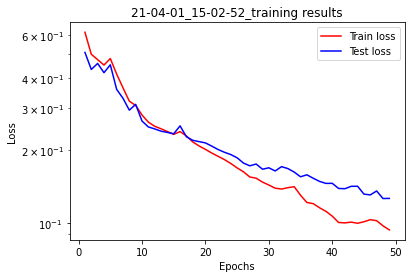

In [6]:
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id, "train")
test_data_dir = os.path.join(basedir, "data", id, "test")
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "_training results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

In [7]:
# pixels = 32
# x = np.arange(pixels) - pixels//2 + 0.5
# xx, yy = np.meshgrid(x, x)
# image = np.zeros((pixels, pixels))
# image += np.exp(-0.5 * np.hypot(xx + 5, yy - 5)**4/1**4)
# image += np.exp(-0.5 * np.hypot(xx - 5, yy + 5)**4/1**4)
# image /= image.sum()
# plt.imshow(image, origin="lower")

In [8]:
for X, Y in train_dataset:
    break

# image = image[np.newaxis, ..., np.newaxis]
image = Y
# X = phys.forward(tf.constant(image, tf.float32))
out, grad = rim.call(X)

In [9]:
index = 30

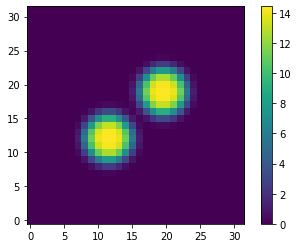

In [10]:
plt.imshow(Y[index, ..., 0], origin="lower")
plt.colorbar()

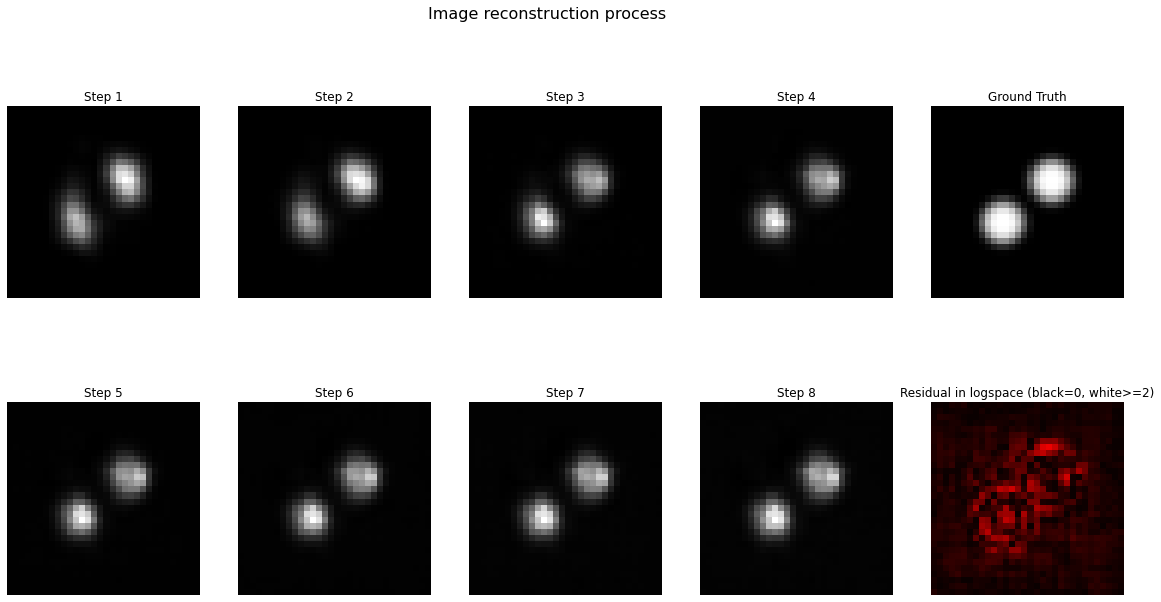

In [11]:
fig,axs = plt.subplots(2, 5, figsize=(20, 10))
k = 0
fig.suptitle("Image reconstruction process", fontsize=16)
for i in range(2):
  for j in range(5):
      if i == 0 and j == 4:
          axs[i, j].imshow(Y[index, ..., 0].numpy(), cmap="gray", origin="lower")
          axs[i, j].axis("off")
          axs[i, j].set_title(f"Ground Truth")
      elif i == 1 and j == 4:
          axs[i, j].imshow(np.abs(out[index, ..., 0, -1].numpy() - np.log(Y[index, ..., 0].numpy() + args.noise_floor)), cmap="hot", origin="lower", vmin=0, vmax=2)
          axs[i, j].axis("off")
          axs[i, j].set_title(f"Residual in logspace (black=0, white>=2)")
      else:
          axs[i, j].imshow(np.exp(out[index, ..., 0, k].numpy()), cmap="gray", origin="lower")
          axs[i, j].axis("off")
          axs[i, j].set_title(f"Step {k+1}")
          k += 1

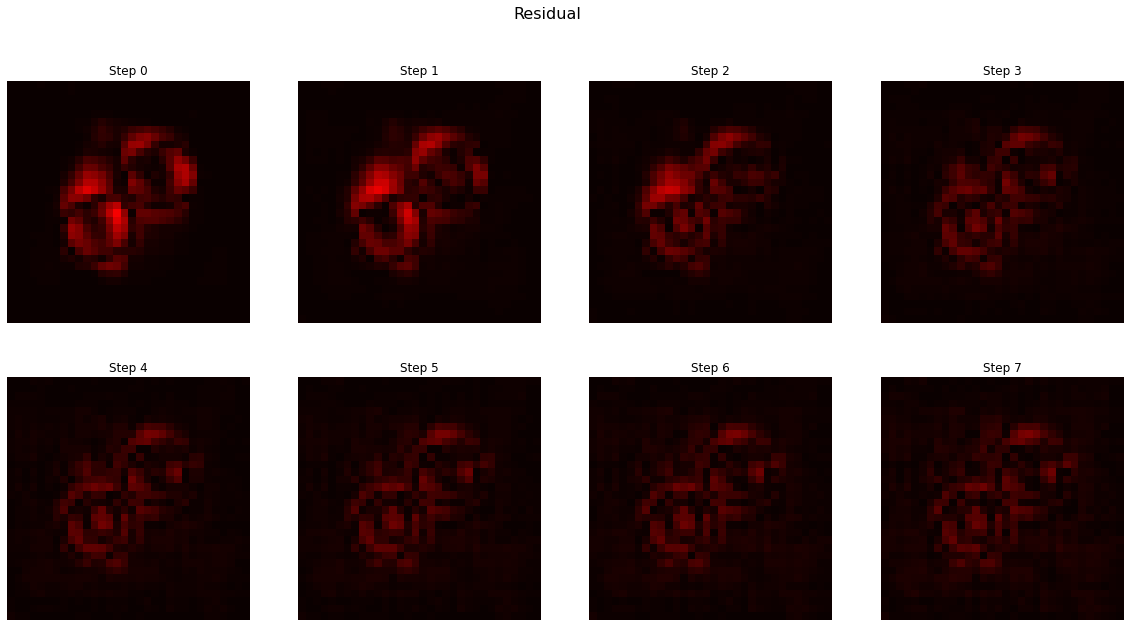

In [12]:
fig,axs = plt.subplots(2, 4, figsize=(20, 10))
k = 0
fig.suptitle("Residual", fontsize=16)
for i in range(2):
  for j in range(4):
    axs[i, j].imshow(np.abs(out[index, ..., 0, k].numpy() - np.log(Y[index, ..., 0].numpy() + args.noise_floor)), cmap="hot", origin="lower", vmin=0, vmax=4)
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Step {k}")
    k += 1

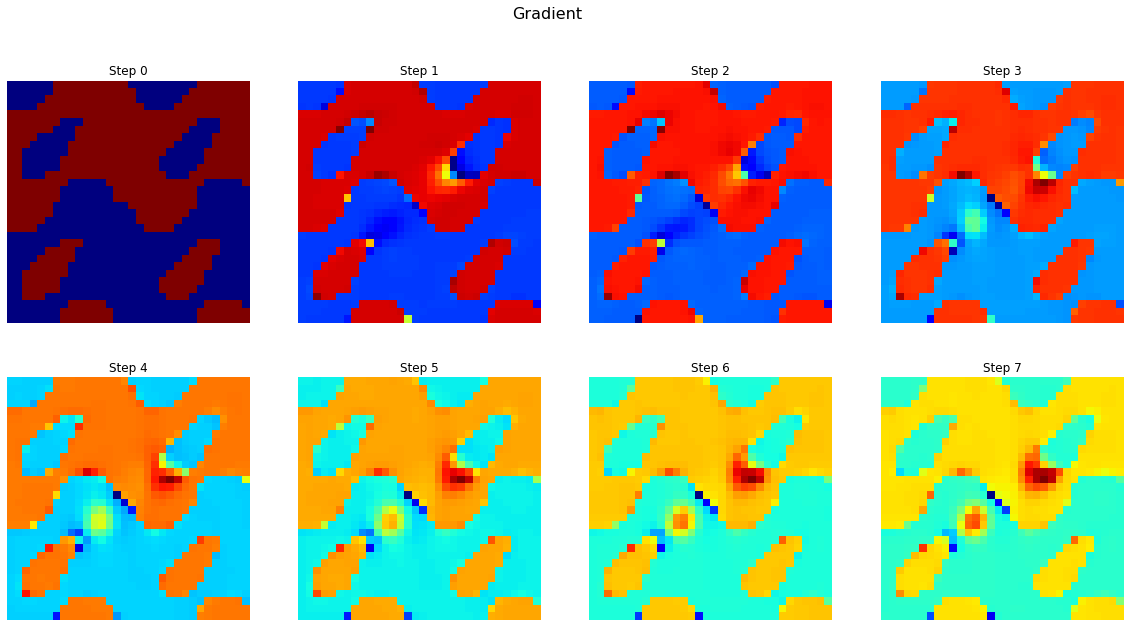

In [13]:
fig,axs = plt.subplots(2, 4, figsize=(20, 10))
k = 0
fig.suptitle("Gradient", fontsize=16)
for i in range(2):
  for j in range(4):
    axs[i, j].imshow(grad[index, ..., k].numpy(), cmap="jet", origin="lower")#, vmin=-1000, vmax=1000)
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Step {k}")
    k += 1

In [14]:
 Thisfft = np.abs(np.fft.fftshift(np.fft.fft2(image[0, ..., 0])))


wavel = args.wavelength
uv = phys.baselines.UVC
rho = np.hypot(uv[:, 0], uv[:, 1])
fov = rad2mas(args.wavelength/rho).max()
plate_scale = fov / pixels # mas
fftfreq = np.fft.fftshift(np.fft.fftfreq(pixels, plate_scale))

im = plt.imshow(np.abs(fft), cmap="hot", extent=[fftfreq.min(), fftfreq.max()]*2)
baselines = Baselines(mask_coordinates=mask)
ufreq = 1/rad2mas(1/baselines.UVC[:, 0]*wavel)
vfreq = 1/rad2mas(1/baselines.UVC[:, 1]*wavel)
plt.plot(ufreq, vfreq, "bo")
plt.colorbar(im)
plt.title("UV coverage")

NameError: ignored

In [ ]:
im = out[0, ..., 1]
im = tf.reshape(im, [1] + im.shape)
X = phys.forward(image)
amp = X[..., :phys.p]
cp = X[..., phys.p:]
print(chisq.chi_squared_amplitude(im, amp, phys))
print(chisq.chi_squared_closure_phasor(im, cp, phys))
# self.lam * entropy(image, self.prior) 

tf.Tensor([9.93524e+09], shape=(1,), dtype=float32)
tf.Tensor([191.9267], shape=(1,), dtype=float32)


In [ ]:
for X, Y in train_dataset:
    break

In [ ]:
tf.exp(out[..., 0]).numpy().max()

6.416682e-13